<a href="https://colab.research.google.com/github/da284/DL_PROJECT_NBA/blob/main/Project_Code/Nework_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
#import useful modules

import sys
import tensorflow as tf
print(sys.version)
print(tf.__version__)
!pip install keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import loadtxt
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.convolutional import AveragePooling1D
from keras.layers import Flatten
from keras.layers import Dropout
from keras import optimizers
from keras.regularizers import l2
from keras.regularizers import l1
from google.colab import output

3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]
2.6.0


In [17]:
################auxiliary functions################

def calc_accuracy(predictions, labels):
  '''Calc the accurarcy by the predictions and the real labels'''
  win_predictions = [1 if pred > 0.5 else 0 for pred in predictions]#convert predictions into zero one predictions
  win_labels = [1 if label > 0.5 else 0 for label in labels]
  accuracy = sum([1 if pred == label else 0 for label, pred in zip(win_labels,win_predictions)])/labels.shape[0]
  return accuracy

def eval_model(model, X, y):
  '''Evaluates the keras model on data X with label y'''
  predictions = model.predict(X)
  return calc_accuracy(predictions, y)
  

def change_labels_to_binary():
  '''Changes the labels to binary, needed for some losses or ML techniques'''
  global train_labels, test_labels
  train_labels = np.where(train_labels > 0.5, 1, 0)
  test_labels = np.where(test_labels > 0.5, 1, 0)

def debug(variable):
  '''Return debug string of the variable'''
  return variable + '=' + repr(eval(variable))

def get_model_string():
  '''Returns string that represents the current model'''
  string = ""
  string += '------------current model------------\n'
  string += debug('CNN') + '\n'
  if CNN:
    for var in ['TRAINING_FILE_NAME','FEATURES_LEN','POOLING','REGULARIZATION','REGULARIZATION_CONST','DROPOUT','BATCH_NORMALIZATION', 'EPOCHS','SGD_EPOCHS','BATCH_SIZE','FILTERS1','FILTERS2', 'CNN_DENSE1', 'CNN_DENSE2', 'VALIDATION_SPLIT', 'OPTIMIZER','LOSS_FN']:
      string += debug(var) + '\n'
  else:
    for var in ['TRAINING_FILE_NAME','FEATURES_LEN','REGULARIZATION','REGULARIZATION_CONST','DROPOUT','BATCH_NORMALIZATION', 'EPOCHS','SGD_EPOCHS','BATCH_SIZE','DENSE1','DENSE2','DENSE3', 'DENSE4', 'DENSE5', 'VALIDATION_SPLIT', 'OPTIMIZER','LOSS_FN']:
      string += debug(var) + '\n'
  string += '-------------------------------------\n'
  return string

def zero_one_accuracy(y_true, y_pred):
  '''Calculates zero one accuracy through the training of the model'''
  y1 = tf.where(y_true > 0.5, 1., 0.)
  y2 = tf.where(y_pred > 0.5, 1., 0.)
  accuracy = tf.where(y1-y2 == 0, 1., 0.)
  return accuracy

def certainty_calculator(model, X, labels, down_threshold, up_threshold):
  '''Calculates the model's guess certainty for some label between the down and up thresholds (distance from 0.5)'''
  #threshold is between 0 and 0.5
  if up_threshold > 0.5 or down_threshold < 0 or down_threshold > up_threshold: 
    raise Exception( "Threshold is problematic" )
  predictions = model.predict(X)
  counter = 0
  sum = 0
  for l, p in zip(labels, predictions):
    if (p > 0.5 + down_threshold and p < 0.5 + up_threshold) or (p < 0.5 - down_threshold and p > 0.5 - up_threshold):#check if the prediction is between the down and up thresholds
      if (l > 0.5 and p > 0.5) or (l <= 0.5 and p <= 0.5):#checks if the model guessed right on the data vector
        sum += 1
      counter += 1
  if counter == 0:
    print("Counter is zero")#no games in this threshold
    return
  print("CERTAINTY CHECK FOR TRESHOLD BETWEEN: {0} AND {1},PERCENTAGE: {2}, CERTAINTY: {3}".format(down_threshold,up_threshold,counter/len(predictions),sum/counter))#print the precentage of the games that are between the threshold values, 
  #and the certainty of guessing right in this thresholds


#######################################################

------------current model------------
CNN=False
TRAINING_FILE_NAME='team_training_8_8_25_2004.csv'
FEATURES_LEN=130
REGULARIZATION=<keras.regularizers.L2 object at 0x7fdd53837050>
REGULARIZATION_CONST=0
DROPOUT=None
BATCH_NORMALIZATION=False
EPOCHS=10
SGD_EPOCHS=10
BATCH_SIZE=32
DENSE1=75
DENSE2=75
DENSE3=75
DENSE4=None
DENSE5=None
VALIDATION_SPLIT=0.1
OPTIMIZER='adam'
LOSS_FN='mean_squared_error'
-------------------------------------

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_110 (Dense)            (None, 75)                9825      
_________________________________________________________________
dense_111 (Dense)            (None, 75)                5700      
_________________________________________________________________
dense_112 (Dense)            (None, 75)                5700      
_________________________________________________________________
dense_113

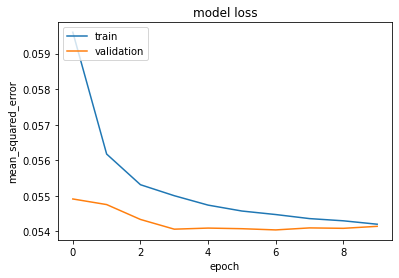

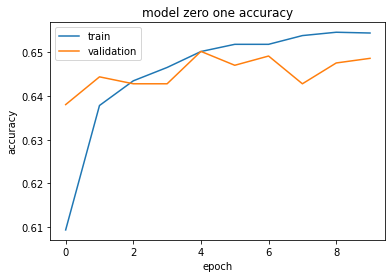

Max zo accuracy on validation:  0.6502384543418884



HISTORY:


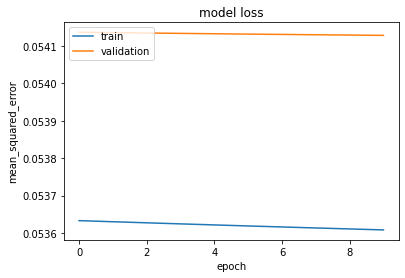

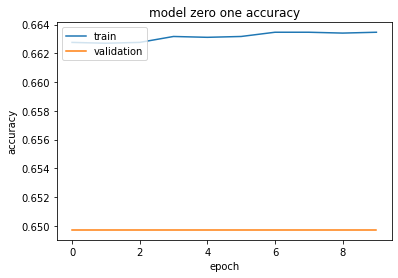

Max zo accuracy on validation:  0.6497085094451904

------------current model------------
CNN=False
TRAINING_FILE_NAME='team_training_8_8_25_2004.csv'
FEATURES_LEN=130
REGULARIZATION=<keras.regularizers.L2 object at 0x7fdd53837050>
REGULARIZATION_CONST=0
DROPOUT=None
BATCH_NORMALIZATION=False
EPOCHS=10
SGD_EPOCHS=10
BATCH_SIZE=32
DENSE1=75
DENSE2=75
DENSE3=75
DENSE4=None
DENSE5=None
VALIDATION_SPLIT=0.1
OPTIMIZER='adam'
LOSS_FN='mean_squared_error'
-------------------------------------



In [37]:
########################IMPORTANT FUNCTIONS###############################

NUM_OF_GAMES_BACKWARD = 8
NUM_OF_FEATURES_PER_GAME = 8
TRAINING_FILE_NAME = 'team_training_' + str(NUM_OF_GAMES_BACKWARD) + '_' + str(NUM_OF_FEATURES_PER_GAME) + '_25_2004.csv'#for team data
TEST_FILE_NAME = 'team_test_' + str(NUM_OF_GAMES_BACKWARD) + '_' + str(NUM_OF_FEATURES_PER_GAME) + '_25_2004.csv'#for team data

NUM_OF_PLAYER_PER_TEAM = 9
NUM_OF_FEATURES_PER_PLAYER = 13
# TRAINING_FILE_NAME = 'player_training_' + str(NUM_OF_PLAYER_PER_TEAM)  + '_' + str(NUM_OF_GAMES_BACKWARD) + '_25.csv'#for player data
# TEST_FILE_NAME = 'player_test_' + str(NUM_OF_PLAYER_PER_TEAM)  + '_' + str(NUM_OF_GAMES_BACKWARD) + '_25.csv'#for player data


VERBOSE = 1
FEATURES_LEN = None #calculated in get_dataset() 
VALIDATION_SPLIT = 0.1

#####PARAMETERS OF THE MODEL######
CNN = False
OPTIMIZER = 'adam'
LOSS_FN = 'mean_squared_error'#'binary_cross_entropy'#'mae'
DROPOUT = None
BATCH_NORMALIZATION = False
REGULARIZATION_CONST = 0
REGULARIZATION = l2(REGULARIZATION_CONST)
###CNN###
POOLING = 'average'
FILTERS1 = 7
FILTERS2 = None
CNN_DENSE1 = 50
CNN_DENSE2 = 50
###DENSE###
DENSE1 = 75
DENSE2 = 75
DENSE3 = 75
DENSE4 = None
DENSE5 = None

################

EPOCHS = 10
SGD_EPOCHS = 10
BATCHES_PER_EPOCH = None #calculated in get_dataset() 
BATCH_SIZE = 32

train_samples = None
train_labels = None
test_samples = None
test_labels = None
MODELS = [] #saves models result in the grid search

def build_model():
  '''Builds model by the global network parameters'''
  if CNN:
    model = Sequential()
    if FILTERS1:
      model.add(Conv1D(filters=FILTERS1, kernel_size=NUM_OF_FEATURES_PER_PLAYER, strides = NUM_OF_FEATURES_PER_PLAYER, activation='relu', input_shape=(FEATURES_LEN,1), kernel_regularizer=REGULARIZATION)) #for players data
      # model.add(Conv1D(filters=FILTERS1, kernel_size=NUM_OF_GAMES_BACKWARD, strides = NUM_OF_GAMES_BACKWARD, activation='relu', input_shape=(FEATURES_LEN,1), kernel_regularizer=REGULARIZATION)) #for teams data
    if BATCH_NORMALIZATION:
      model.add(BatchNormalization())
    if FILTERS2:
      if DROPOUT:
        model.add(Dropout(DROPOUT))
      # model.add(Conv1D(filters=FILTERS2, kernel_size=NUM_OF_FEATURES_PER_GAME, strides = NUM_OF_FEATURES_PER_GAME, activation='relu', kernel_regularizer=REGULARIZATION)) #for team data
      model.add(Conv1D(filters=FILTERS2, kernel_size=NUM_OF_PLAYER_PER_TEAM, strides = NUM_OF_PLAYER_PER_TEAM, activation='relu', kernel_regularizer=REGULARIZATION)) #for player data
    if DROPOUT:
      model.add(Dropout(DROPOUT))
    if POOLING:
      if POOLING == 'max':
        model.add(MaxPooling1D(pool_size=NUM_OF_PLAYER_PER_TEAM))
      elif POOLING == 'average':
        model.add(AveragePooling1D(pool_size=NUM_OF_PLAYER_PER_TEAM))
      else:
        raise ValueError('Mistake in the pooling variable')
    model.add(Flatten())
    if CNN_DENSE1:
      model.add(Dense(CNN_DENSE1, activation='relu', kernel_regularizer=REGULARIZATION))
    if CNN_DENSE2:
      model.add(Dense(CNN_DENSE1, activation='relu', kernel_regularizer=REGULARIZATION))
    model.add(Dense(1, activation='sigmoid'))
  else: #builds fully connected network
    model = Sequential()
    model.add(Dense(DENSE1, input_dim=FEATURES_LEN, activation='relu', kernel_regularizer=REGULARIZATION))
    if DENSE2:
      model.add(Dense(DENSE2, activation='relu', kernel_regularizer=REGULARIZATION))
      if DROPOUT:
        model.add(Dropout(DROPOUT))
      if BATCH_NORMALIZATION:
        model.add(BatchNormalization())
    if DENSE3:
      model.add(Dense(DENSE3, activation='relu', kernel_regularizer=REGULARIZATION))
    if DENSE4:
      model.add(Dense(DENSE4, activation='relu', kernel_regularizer=REGULARIZATION))
    if DENSE5:
      model.add(Dense(DENSE5, activation='relu', kernel_regularizer=REGULARIZATION))
    model.add(Dense(1, activation='sigmoid'))
  optimizer = OPTIMIZER
  if optimizer == 'sgd':
    learning_rate = 0.1
    decay_rate = 1e-6 #learning_rate / EPOCHS
    momentum = 0.8
    optimizer = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
  loss_fn = LOSS_FN
  if LOSS_FN == 'mae':
    loss_fn = tf.keras.losses.MeanAbsoluteError()
  if LOSS_FN == 'binary_cross_entropy':
    loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    change_labels_to_binary() #need to change labels for binary cross entropy loss
  model.compile(loss=loss_fn, optimizer=optimizer, metrics=[zero_one_accuracy])#'mse', 'mae' #compile the model
  return model
  

def get_dataset():
  '''Get the dataset from the respective files, if CNN is true, changes the shape of the samples'''
  global train_samples, train_labels, test_samples, test_labels, FEATURES_LEN, BATCHES_PER_EPOCH
  # load the training set
  dataset = np.asarray(pd.read_csv('drive/MyDrive/' + TRAINING_FILE_NAME, delimiter=',').values.tolist())
  np.random.shuffle(dataset)
  train_samples = dataset[:,0:-1]
  train_labels = dataset[:,-1]
  FEATURES_LEN = train_samples.shape[1] #get the number of features from dataset
  if not BATCHES_PER_EPOCH:
    BATCHES_PER_EPOCH = int((train_samples.shape[0]*(1-VALIDATION_SPLIT)/BATCH_SIZE))#calculate how many batches there are for one epoch
  # load the test set
  dataset = np.asarray(pd.read_csv('drive/MyDrive/' + TEST_FILE_NAME, delimiter=',').values.tolist())
  test_samples = dataset[:,0:-1]
  test_labels = dataset[:,-1]
  if CNN:
    train_samples = train_samples.reshape((len(train_samples),FEATURES_LEN,1))
    test_samples = test_samples.reshape((len(test_samples),FEATURES_LEN,1))

def print_history(history):
  '''Prints the history of the model, returns maximum of the validation'''
  print('\n\nHISTORY:')
  #prints the loss graph
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel(LOSS_FN)
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()
  print()
  # prints the accuracy graph
  plt.plot(history.history['zero_one_accuracy'])
  plt.plot(history.history['val_zero_one_accuracy'])
  plt.title('model zero one accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()
  max_result = np.max(history.history['val_zero_one_accuracy'])
  print("Max zo accuracy on validation: ", max_result)
  print()
  return max_result #return max validation result



def train_and_validate(model_num):
  '''train and validate the model, and saves the result in the MODELS array'''
  # create model
  model = build_model()
  print(model.summary())
  # create checkpoint for saving best model
  filepath="model_num=" + str(model_num) + ",epoch={epoch:03d}.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor='val_zero_one_accuracy', verbose=1, mode='max', save_weights_only=True,
    save_freq=BATCHES_PER_EPOCH*5)#save_best_only=True)#save best model to the file
  # es = EarlyStopping(monitor='val_zero_one_accuracy', mode='max', verbose=1, baseline=0.62, patience=0)
  filepath="model_num=" + str(model_num) + ",epoch={epoch:03d}(sgd).hdf5"
  sgd_checkpoint = ModelCheckpoint(filepath, monitor='val_zero_one_accuracy', verbose=1, mode='max', save_weights_only=True,
    save_freq=BATCHES_PER_EPOCH*5)#save the model's weights in a file
  callbacks_list = [checkpoint]
  # fit the model using adam and then sgd
  adam_history = model.fit(train_samples, train_labels, validation_split=VALIDATION_SPLIT, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks_list, verbose=VERBOSE, shuffle=False)
  #changes optimizer to sgd with small learning rate
  model.compile(loss='mse', optimizer=SGD(learning_rate=0.00001), metrics=['mse', 'mae', zero_one_accuracy])
  callbacks_list = [sgd_checkpoint]
  sgd_history = model.fit(train_samples, train_labels, validation_split=VALIDATION_SPLIT, epochs=SGD_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks_list, verbose=VERBOSE, shuffle=False)
  max_result = print_history(adam_history)
  sgd_max_result = print_history(sgd_history)
  max_result = max(sgd_max_result, max_result)
  model_string = get_model_string()
  # save the models in list of dictionaries
  keys = ['model','max_result', 'adam_history', 'model_string']
  model_dictionary = {}
  for key in keys:
    model_dictionary[key] = eval(key)
  MODELS.append(model_dictionary)   
    

def grid_search(cnn):
  '''grid search on the model with some parameters, gets the value of the CNN variable'''
  global BATCH_NORMALIZATION, DROPOUT,DENSE1, DENSE2, DENSE3, DENSE4, LOSS_FN, OPTIMIZER, EPOCHS, CNN, FILTERS1, FILTERS2, CNN_DENSE1, REGULARIZATION_CONST
  CNN = cnn
  EPOCHS = 150
  model_num = 0
  get_dataset()
  for rc in [0,1e-6,5e-6,1e-5,4e-5,7e-5,1e-4]:
    REGULARIZATION_CONST = rc
    for optimizer in ['adam']:
      OPTIMIZER = optimizer
      if CNN:
        for filters1 in [5]:
          FILTERS1 = filters1
          for filters2 in [None]:
            FILTERS2 = filters2
            for cnn_dense1 in [200]:
              CNN_DENSE1 = cnn_dense1
              train_and_validate(model_num)
              model_num += 1
              print(get_model_string())
      else:
        for width in [25,50,100,150,200,250]:
          DENSE1 = DENSE2 = DENSE3 = DENSE4 = width
          train_and_validate(model_num)
          model_num += 1
          print(get_model_string())

def check_model():
  '''Check the model with the current global variables''' 
  get_dataset()
  print(get_model_string())#print the model's variables
  train_and_validate(0)
  print(get_model_string())

def main():
  check_model()
  # grid_search(cnn = False)
  pass

if __name__ == "__main__":
  main()
  output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()') #beeps when finished to run

########################################################################

In [36]:
##########Check the final model############

#the final model paramters
NUM_OF_GAMES_BACKWARD = 8
NUM_OF_FEATURES_PER_GAME = 8
TRAINING_FILE_NAME = 'team_training_' + str(NUM_OF_GAMES_BACKWARD) + '_' + str(NUM_OF_FEATURES_PER_GAME) + '_25_2004.csv'
TEST_FILE_NAME = 'team_test_' + str(NUM_OF_GAMES_BACKWARD) + '_' + str(NUM_OF_FEATURES_PER_GAME) + '_25_2004.csv'
DENSE1 = 75
DENSE2 = 75
DENSE3 = 75
DENSE4 = 75

def build_model():
  '''Builds the final model'''
  model = Sequential()
  model.add(Dense(DENSE1, input_dim=FEATURES_LEN, activation='relu'))
  model.add(Dense(DENSE2, activation='relu'))
  model.add(Dense(DENSE3, activation='relu'))
  model.add(Dense(DENSE4, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  return model

def plot_density(x, data_name):
  '''Plots the density of x'''
  num_bins = 20
  n, bins, patches = plt.hist(x, num_bins, 
                            density = 1, 
                            range = (0,1),
                            color ='green',
                            alpha = 0.7)
  
  plt.xlabel('Label')
  plt.ylabel('Density')
  
  plt.title('Density hist of the {}\n'.format(data_name),
          fontweight ="bold")
  
  plt.show()

def main():
  '''Test the final model'''
  #get test data
  get_dataset()
  model = build_model()
  filepath = "drive/MyDrive/model_weights.hdf5"
  model.load_weights(filepath)
  test_acc = eval_model(model, test_samples, test_labels)#evaluate the model
  print(test_acc)
  for down, up in zip([0, 0.08, 0.12],[0.08, 0.12, 0.5]):#calculate certainty for some thresholds
    certainty_calculator(model, test_samples, test_labels, down_threshold=down, up_threshold=up)
  
  # plot_density(model.predict(test_samples), "test samples")
  # plot_density(train_labels, "train labels")
  

if __name__ == "__main__":
  main()

##################################################

0.6677804295942721
CERTAINTY CHECK FOR TRESHOLD BETWEEN: 0 AND 0.08,PERCENTAGE: 0.30978520286396183, CERTAINTY: 0.588597842835131
CERTAINTY CHECK FOR TRESHOLD BETWEEN: 0.08 AND 0.12,PERCENTAGE: 0.3818615751789976, CERTAINTY: 0.65875
CERTAINTY CHECK FOR TRESHOLD BETWEEN: 0.12 AND 0.5,PERCENTAGE: 0.30835322195704057, CERTAINTY: 0.7585139318885449


In [ ]:
##########Trying some ML techniques##########

# TRAINING_FILE_NAME = 'player_training_3_8_25.csv'
# TEST_FILE_NAME = 'player_test_3_8_25.csv'

from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn import linear_model

get_dataset()

print(TRAINING_FILE_NAME)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(train_samples, train_labels)

# Make predictions using the testing set
predictions = regr.predict(test_samples)
lr_acc = calc_accuracy(predictions, test_labels)

print("LINEAR REGRESSION GOT ACCURACY OF {0}".format(lr_acc))


change_labels_to_binary()#change the labels to 0 and 1 for svm and decision tree


#Create a svm Classifier
for kernel in ('linear', 'poly', 'rbf'):

  clf = svm.SVC(kernel=kernel) # Linear Kernel

  #Train the model using the training sets
  clf.fit(train_samples, train_labels)

  #Predict the response for test dataset
  predictions = clf.predict(test_samples)
  svm_acc = calc_accuracy(predictions, test_labels)

  print("SVM GOT ACCURACY OF {0} WITH {1} KERNEL".format(svm_acc, kernel.upper()))

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()


# Train Decision Tree Classifer
clf = clf.fit(train_samples,train_labels)

#Predict the response for test dataset
predictions = clf.predict(test_samples)
tree_acc = calc_accuracy(predictions, test_labels)

print("DESICION TREE GOT ACCURACY OF {0}".format(tree_acc))
############################################

team_training_8_8_25_2004.csv
LINEAR REGRESSION GOT ACCURACY OF 0.6572792362768496
SVM GOT ACCURACY OF 0.6568019093078759 WITH LINEAR KERNEL
